In [1]:
#TODO add STRUCT variables from dwarf info

from elftools.elf.elffile import ELFFile
from elftools.dwarf.descriptions import (
    describe_DWARF_expr, set_global_machine_arch)
from elftools.dwarf.locationlists import (
    LocationEntry, LocationExpr, LocationParser)
import posixpath
import sys,os
from elftools.elf.segments import Segment


from collections import defaultdict

import collections
import posixpath

import networkx as nx
from pyvis.network import Network
net = Network(notebook=True)
import matplotlib
import matplotlib.pyplot


binFileName = 'stacktest'
# filePath = './../../binaries/gnuit/src/' + binFileName

filePath = './../../binaries/c_many/'+binFileName




In [2]:
# https://www.capstone-engine.org/lang_python.html



from capstone import *

from capstone.x86 import *



def get_valid_addresses (filePath):
    
    fh = open(filePath, 'rb')
    bin_bytearray = bytearray(fh.read())

    address_inst = {}
    with open(filePath, 'rb') as f:
        elf = ELFFile(f)
        dwarfinfo = elf.get_dwarf_info()
        aranges = dwarfinfo.get_aranges()
        print(len(aranges.entries))
        for arange in aranges.entries:
            print(arange)
        for arange in aranges.entries:

            entry = arange.begin_addr
            exit  = arange.begin_addr + arange.length
            ops = bin_bytearray[entry: exit]

            md = Cs(CS_ARCH_X86, CS_MODE_64)
            md.detail = True
            for inst in md.disasm(ops, entry):
                address_inst[inst.address] = inst
                
    address_inst = collections.OrderedDict(sorted(address_inst.items()))
    return address_inst
            
VALID_INSTRUCTIONS_SET = get_valid_addresses(filePath)
VALID_INSTRUCTIONS_SET

3
ARangeEntry(begin_addr=4521, length=488, info_offset=0, unit_length=44, version=2, address_size=8, segment_size=0)
ARangeEntry(begin_addr=5009, length=415, info_offset=990, unit_length=44, version=2, address_size=8, segment_size=0)
ARangeEntry(begin_addr=5424, length=200, info_offset=1562, unit_length=44, version=2, address_size=8, segment_size=0)


OrderedDict([(4521, <CsInsn 0x11a9 [f30f1efa]: endbr64 >),
             (4525, <CsInsn 0x11ad [55]: push rbp>),
             (4526, <CsInsn 0x11ae [4889e5]: mov rbp, rsp>),
             (4529, <CsInsn 0x11b1 [4883ec30]: sub rsp, 0x30>),
             (4533, <CsInsn 0x11b5 [897ddc]: mov dword ptr [rbp - 0x24], edi>),
             (4536,
              <CsInsn 0x11b8 [488975d0]: mov qword ptr [rbp - 0x30], rsi>),
             (4540,
              <CsInsn 0x11bc [c745e80a000000]: mov dword ptr [rbp - 0x18], 0xa>),
             (4547,
              <CsInsn 0x11c3 [c745ec0c000000]: mov dword ptr [rbp - 0x14], 0xc>),
             (4554,
              <CsInsn 0x11ca [488b45d0]: mov rax, qword ptr [rbp - 0x30]>),
             (4558, <CsInsn 0x11ce [488b00]: mov rax, qword ptr [rax]>),
             (4561,
              <CsInsn 0x11d1 [488945f0]: mov qword ptr [rbp - 0x10], rax>),
             (4565, <CsInsn 0x11d5 [bf10000000]: mov edi, 0x10>),
             (4570, <CsInsn 0x11da [e8d1feffff]: cal

In [3]:

def line_entry_mapping(line_program,CU):
    filename_map = defaultdict(int)

    # The line program, when decoded, returns a list of line program
    # entries. Each entry contains a state, which we'll use to build
    # a reverse mapping of filename -> #entries.
    lp_entries = line_program.get_entries()
    if len(lp_entries)==0:
        return None
    for lpe in lp_entries:
        # We skip LPEs that don't have an associated file.
        # This can happen if instructions in the compiled binary
        # don't correspond directly to any original source file.
        if not lpe.state:# or lpe.state.file == 0
            continue
        filename = lpe_filename(line_program, lpe.state.file,CU)[0]
        filename_map[filename] += 1

    # for filename, lpe_count in filename_map.items():
    #     print("    filename=%s -> %d entries" % (filename, lpe_count))
    return filename_map

def lpe_filename(line_program, file_index, CU):
    
    
    die_dict = {}                    
    for attr in CU.get_top_DIE().attributes.values():
        die_dict[attr.name] = attr
    
    
    compilation_command = die_dict['DW_AT_producer'].value.decode("utf-8")
    
    if 'clang' in compilation_command.lower():
        COMPILER_SUBSTRACT = 1
    elif 'gnu' in compilation_command.lower():
        COMPILER_SUBSTRACT = 0
    lp_header = line_program.header
    file_entries = lp_header["file_entry"]
#     print(COMPILER_SUBSTRACT, compilation_command)
    
    # File and directory indices are 1-indexed.
    file_entry = file_entries[file_index -COMPILER_SUBSTRACT]
    dir_index = file_entry["dir_index"]

    # A dir_index of 0 indicates that no absolute directory was recorded during
    # compilation; return just the basename.
    if dir_index == 0:
        return file_entry.name.decode(),dir_index
    directory = lp_header["include_directory"][dir_index -COMPILER_SUBSTRACT]
    return posixpath.join(directory, file_entry.name).decode(),dir_index


def show_loclist(loclist, dwarfinfo, indent, cu_offset):
    """ Display a location list nicely, decoding the DWARF expressions
        contained within.
    """
    d = []
    for loc_entity in loclist:
        if isinstance(loc_entity, LocationEntry):
            d.append('%s <<%s>>' % (
                loc_entity,
                describe_DWARF_expr(loc_entity.loc_expr, dwarfinfo.structs, cu_offset)))
        else:
            d.append(str(loc_entity))
    return '\n'.join(indent + s for s in d)


########################################################
######################   DWARF PERSER #######################
###########################################################


def get_DIE_at_offset(CU, offset):
        for die in CU.iter_DIEs():
            if die.offset == CU.cu_offset+offset:
                return die 
        return None


##TODO FIX CONSTANT TYPE
def get_type_name(CU, offset):#get_DIE_at_offset(CU,attr.value)
    die = get_DIE_at_offset(CU, offset)
    
    if die.tag == 'DW_TAG_const_type':
        return "const"
    
    if die.tag == 'DW_TAG_pointer_type' :
        for _attr in die.attributes.values():
            if _attr.name== "DW_AT_type":
                
                return "*"+get_type_name(CU, _attr.value) 

    elif die.tag =='DW_TAG_subroutine_type':
        

        for _attr in die.attributes.values():
            if _attr.name== "DW_AT_sibling":
                return get_type_name(CU, _attr.value) 
            
            if _attr.name== "DW_AT_type":
                return "*"+get_type_name(CU, _attr.value) 

    for attr in die.attributes.values():
        if attr.name== "DW_AT_name":
            return attr.value.decode("utf-8")


    
    

    
############################################################
############################# CLANG #######################
###########################################################

# FUNCTION_DECL
# https://stackoverflow.com/questions/43460605/function-boundary-identification-using-libclang
# https://eli.thegreenplace.net/2011/07/03/parsing-c-in-python-with-clang


import clang.cindex
from clang.cindex import CursorKind


def get_all_var_types(source_path):
    srcFileName = source_path.split('/')[-1]
    idx = clang.cindex.Index.create()
    tu = idx.parse(source_path)
    
    for f in tu.cursor.walk_preorder():
        if f.kind == clang.cindex.CursorKind.VAR_DECL:
            # print(dir(f))
            print('file.name: ',f.extent.start.file.name)
            originFileName = f.extent.start.file.name.split('/')[-1]
            print('originFileName :',originFileName)
            print('displayname:  ',f.displayname)
            print('type.spelling:  ',f.type.spelling)
            print('f.extent.start.line: ', f.extent.start.line, "col: ",f.extent.start.column)
            print('\n')
            
            

   

def get_all_function_types(source_path):
    function_boundary_by_name = {}
    idx = clang.cindex.Index.create()
    tu = idx.parse(source_path)
    
    for f in tu.cursor.walk_preorder():
        if f.kind == clang.cindex.CursorKind.FUNCTION_DECL:
            # print(dir(f))
            print(f.displayname)
            print('function name: ',( f.spelling))
            print('Returns: ',(f.result_type.spelling))
            
            
            arg_len = len(list(f.type.argument_types()))
            if arg_len>0:
                arg_types = list(f.type.argument_types())
                for arg_type in arg_types:
                    print('arg_type:',arg_type.spelling)
                args = list(f.get_arguments())
                for arg in args:
                    print('arg:',arg.spelling)


            print("\n\n\n")

            
def get_function_boundaries(source_path):
    
    function_boundary_by_name = {}
    idx = clang.cindex.Index.create()
    tu = idx.parse(source_path)
    
    for f in tu.cursor.walk_preorder():
        if f.kind == clang.cindex.CursorKind.FUNCTION_DECL:

            function_name = f.displayname.split('(')[0]
            function_boundary_by_name[function_name]={}
            function_boundary_by_name[function_name] = { 'src_path':f.extent.start.file.name,
                              'src_file':f.extent.start.file.name.split('/')[-1],
                              'start_line':f.extent.start.line,
                              'start_col':f.extent.start.column,
                              'end_line':f.extent.end.line,
                              'end_col':f.extent.end.column}
    return function_boundary_by_name

def get_containing_function(source_file_path, line, col=0):
    function_boundary_by_name = get_function_boundaries(source_file_path)
    
    for function_name, item in function_boundary_by_name.items():
        if item['src_path'] == source_file_path:
            if line>= item['start_line'] and line<= item['end_line']:
                return function_name
        
# _=get_function_boundaries('/home/nahid/reverse/binaries/c_many/stack.c' )

def form_function_bound_metrix(src_bounds, src_file_name):
    bounds = {}
    for func_info in src_bounds.items():
        if func_info[1]['src_file'] == src_file_name:
            start_line  = func_info[1]['start_line']
            end_line    = func_info[1]['end_line']
            print(func_info[0] ,start_line , end_line)
            for i in range(start_line , end_line+1):
                bounds[i] = func_info[0]
               
    return bounds



def find_variables_per_line(source_path , line_to_function_matrix , dwarf_FUNC_PARAMS):
    srcFileName = source_path.split('/')[-1]
    idx = clang.cindex.Index.create()
    tu = idx.parse(source_path)
    var_usage_matrix = {}
    for f in tu.cursor.walk_preorder():
#         if f.extent.start.file.name.split('/')[-1] in ['stack.c']:
#             print(f.extent.start.file.name.split('/')[-1])
#             print("line--: ",f.extent.start.line)
#             print(f.kind)
#             print(f.displayname, f.type.spelling)
        
        #TODO keep all with type info, explore CursorKind
        #TODO function ends  }  should relate with fucntion return type
        
        if f.kind in [CursorKind.PARM_DECL ,CursorKind.DECL_REF_EXPR, CursorKind.VAR_DECL]  :
            
            originFileName = f.extent.start.file.name.split('/')[-1]
            
            if srcFileName!=originFileName:
                continue

#             print('\n\noriginFileName :',originFileName)
#             print('displayname:  ',f.displayname)
#             print('type.spelling:  ',f.type.spelling)
#             print('f.extent.start.line: ', f.extent.start.line, "col: ",f.extent.start.column )
            
            line = f.extent.start.line
            col =f.extent.start.column
            type_info = f.type.spelling
            var_name = f.displayname
            
            if line not in var_usage_matrix:
                var_usage_matrix[line] = {}
            if var_name in dwarf_FUNC_PARAMS[source_path][line_to_function_matrix[line]]:
                var_usage_matrix[line][col] = {
                                'name'       : f.displayname ,
                                'dwarf_info' : dwarf_FUNC_PARAMS[source_path][line_to_function_matrix[line]][var_name],
                                'type'       : f.type.spelling }
    return var_usage_matrix

            
###################################################################
########  Find Src Code by filepath, line and col no  #############
##################################################################

def getSource(sourceFilePath, row , col):
    print(sourceFilePath, row , col)
    sourceFile = open(sourceFilePath, "r")
    fileContent = sourceFile.readlines()
    row_content =  fileContent[row-1]
    row_content = row_content[:(col-1)] + '|'+row_content[(col-1)]+'|' +row_content[col:]
    
    return row_content



In [4]:
# dir(clang.cindex.CursorKind)

In [5]:

##############################################################################
#################   RELATE FUNCTIONS TO ADDRESSES #############################
###############################################################################

import collections
            

lineinfo_address_subprogram = {}
with open(filePath, 'rb') as f:
    elffile = ELFFile(f)

    if not elffile.has_dwarf_info():
        print('  file has no DWARF info')
        exit(0)

    dwarfinfo = elffile.get_dwarf_info()
    for CU in dwarfinfo.iter_CUs():
#         print(CU.get_top_DIE()['DW_AT_comp_dir'])
        CU_DIR_PATH = None
        CU_FILENAME = None
        for attr in CU.get_top_DIE().attributes.values():
            if attr.name == 'DW_AT_comp_dir':
                CU_DIR_PATH = attr.value.decode("utf-8")
            if attr.name == 'DW_AT_name':
                CU_FILENAME = attr.value.decode("utf-8")
        
        print('  Found a compile unit at offset %s, length %s' % (
            CU.cu_offset, CU['unit_length']))

        # Every compilation unit in the DWARF information may or may not
        # have a corresponding line program in .debug_line.
        line_program = dwarfinfo.line_program_for_CU(CU)
        if line_program is None:
            print('  DWARF info is missing a line program for this CU')
            continue
        
        cu_file_path  = os.path.join(CU_DIR_PATH, CU_FILENAME)
        print(cu_file_path)
        
    
        bounds_matrix = form_function_bound_metrix( get_function_boundaries(cu_file_path)  , CU_FILENAME)
        for line_entry in line_program.get_entries():
          
            if line_entry.state!= None:
                lineinfo_address_subprogram[line_entry.state.address]  =   {
                    'func':bounds_matrix[line_entry.state.line],
                    'srcPath':cu_file_path,
                    'lineinfo':line_entry.state
                } 

#TODO make efficient with valid address only

lineinfo_address_subprogram = collections.OrderedDict(sorted(lineinfo_address_subprogram.items()))
lineinfo_address_subprogram_complete = {}

min_address = min(lineinfo_address_subprogram.keys())
max_address = max(lineinfo_address_subprogram.keys())

temp_subprogram = lineinfo_address_subprogram[min_address]
for i in range(min_address,max_address+1):
    if i in lineinfo_address_subprogram:
        temp_subprogram = lineinfo_address_subprogram[i]
    lineinfo_address_subprogram_complete[i] = temp_subprogram
lineinfo_address_subprogram_complete




  Found a compile unit at offset 0, length 986
/home/nahid/reverse/binaries/c_many/stack.c
push 6 18
dummy 19 37
pop 39 51
fake 53 65
  Found a compile unit at offset 990, length 568
/home/nahid/reverse/binaries/c_many/main.c
main 7 30
  Found a compile unit at offset 1562, length 484
/home/nahid/reverse/binaries/c_many/calculate.c
add 5 17
addf 18 20
substract 23 25
substractf 26 28


{4521: {'func': 'push',
  'srcPath': '/home/nahid/reverse/binaries/c_many/stack.c',
  'lineinfo': <LineState 7fb2cc240fa0:
    address = 0x11a9
    file = 1
    line = 6
    column = 40
    is_stmt = 1
    basic_block = False
    end_sequence = False
    prologue_end = False
    epilogue_begin = False
    isa = 0
    discriminator = 0>},
 4522: {'func': 'push',
  'srcPath': '/home/nahid/reverse/binaries/c_many/stack.c',
  'lineinfo': <LineState 7fb2cc240fa0:
    address = 0x11a9
    file = 1
    line = 6
    column = 40
    is_stmt = 1
    basic_block = False
    end_sequence = False
    prologue_end = False
    epilogue_begin = False
    isa = 0
    discriminator = 0>},
 4523: {'func': 'push',
  'srcPath': '/home/nahid/reverse/binaries/c_many/stack.c',
  'lineinfo': <LineState 7fb2cc240fa0:
    address = 0x11a9
    file = 1
    line = 6
    column = 40
    is_stmt = 1
    basic_block = False
    end_sequence = False
    prologue_end = False
    epilogue_begin = False
    isa = 0
    d

In [6]:
# https://github.com/eliben/pyelftools/blob/master/examples/dwarf_location_info.py

from elftools.dwarf.locationlists import LocationParser, LocationExpr
FUNC_PARAMS = {}

def process_file(filename):
    print('Processing file:', filename)
    with open(filename, 'rb') as f:
        elffile = ELFFile(f)

        if not elffile.has_dwarf_info():
            print('  file has no DWARF info')
            return

        # get_dwarf_info returns a DWARFInfo context object, which is the
        # starting point for all DWARF-based processing in pyelftools.
        dwarfinfo = elffile.get_dwarf_info()
        # The location lists are extracted by DWARFInfo from the .debug_loc
        # section, and returned here as a LocationLists object.
        location_lists = dwarfinfo.location_lists()
        

        # This is required for the descriptions module to correctly decode
        # register names contained in DWARF expressions.
        set_global_machine_arch(elffile.get_machine_arch())

        # Create a LocationParser object that parses the DIE attributes and
        # creates objects representing the actual location information.
        loc_parser = LocationParser(location_lists)
        section_offset = dwarfinfo.debug_info_sec.global_offset
        # Offset of the .debug_info section in the stream
        
        
        for CU in dwarfinfo.iter_CUs():
            CU_DIR_PATH = None
            CU_FILENAME = None
            for attr in CU.get_top_DIE().attributes.values():
                if attr.name == 'DW_AT_comp_dir':
                    CU_DIR_PATH = attr.value.decode("utf-8")
                if attr.name == 'DW_AT_name':
                    CU_FILENAME = attr.value.decode("utf-8")

            line_program = dwarfinfo.line_program_for_CU(CU)
            filename_map = line_entry_mapping(line_program,CU)
            if filename_map==None:
                continue
         
            CU_dictionary_key = os.path.join(CU_DIR_PATH, CU_FILENAME)
            if CU_dictionary_key not in FUNC_PARAMS:
                FUNC_PARAMS[CU_dictionary_key] = {}
            
            print('  Found a compile unit at offset %s, length %s' % (
                CU.cu_offset, CU['unit_length']))

            # A CU provides a simple API to iterate over all the DIEs in it.
            die_depth = 0
            are_DIEs_of_function = False
            FUNC_name = None
            for DIE in CU.iter_DIEs():
                
                ############################################################
                #############   Prasing Function DIEs start ################
                
                
                if DIE.tag == 'DW_TAG_subprogram':
                    if 'DW_AT_low_pc' in DIE.attributes and 'DW_AT_high_pc' in DIE.attributes :
                        low_pc = DIE.attributes['DW_AT_low_pc'].value
                        high_pc = DIE.attributes['DW_AT_high_pc'].value
                        
                        print("Low PC: ",hex(low_pc) , " High PC" , hex(high_pc))
                    else:
                        print("NO PC given")
                    are_DIEs_of_function = True
                    
                    for attr in DIE.attributes.values():
                        if attr.name == "DW_AT_name": #FUNC NAME
                            FUNC_name = attr.value.decode("utf-8")
                            if FUNC_name not in FUNC_PARAMS[CU_dictionary_key]:
                                FUNC_PARAMS[CU_dictionary_key][FUNC_name] ={}
                            print("SUBPROGRAM: ",FUNC_name)
                            
                if DIE.tag in[ 'DW_TAG_formal_parameter','DW_TAG_variable' ,'DW_TAG_member']:
                    tags = [attr.name for attr in DIE.attributes.values()]
                    PARAM_name = None
                    if FUNC_name==None:
                        
                        FUNC_name ="global"
                        
                        if FUNC_name not in FUNC_PARAMS[CU_dictionary_key]:
                            FUNC_PARAMS[CU_dictionary_key][FUNC_name]={}
                        
                    if "DW_AT_name" in tags:
                        
                        die_dict = {}
                        
                        for attr in DIE.attributes.values():
                            die_dict[attr.name] = attr
                        
                        PARAM_name = die_dict['DW_AT_name'].value.decode("utf-8")
                        
                        if PARAM_name not in FUNC_PARAMS[CU_dictionary_key][FUNC_name]:
                            FUNC_PARAMS[CU_dictionary_key][FUNC_name][PARAM_name] = {}
                        var_type = DIE.tag.split('_')[-1]
                        FUNC_PARAMS[CU_dictionary_key][FUNC_name][PARAM_name] = {'type':get_type_name(CU,die_dict['DW_AT_type'].value) , 'kind':var_type}
                        
#                         print(die_dict)
                        # Check if this attribute contains location information
#                         if loc_parser.attribute_has_location(die_dict['DW_AT_location'], CU['version']):
                        if 'DW_AT_location' in die_dict:

                            try:
                                loc = loc_parser.parse_from_attribute(die_dict['DW_AT_location'],
                                                                      CU['version'])
                                
#                                 print(CU_dictionary_key,FUNC_name,PARAM_name)
                                if isinstance(loc, LocationExpr):
                                    loc_info_str = describe_DWARF_expr(loc.loc_expr, dwarfinfo.structs, CU.cu_offset)
                                    offset_temp = (loc_info_str.split('-')[-1]).split(')')[0]
#                                     print('1a ',loc_info_str, offset_temp)
#                                     print('1b ', PARAM_name,loc_info_str, int(offset_temp)-LOCATION_SUBSTRACT_FACTOR)
                                    FUNC_PARAMS[CU_dictionary_key][FUNC_name][PARAM_name]["location"]= loc_info_str

                                elif isinstance(loc, list):
                                    print(PARAM_name,show_loclist(loc,dwarfinfo,'      ', CU.cu_offset))
                                    FUNC_PARAMS[CU_dictionary_key][FUNC_name][PARAM_name]["location"]= show_loclist(loc,
                                                       dwarfinfo,'      ', CU.cu_offset)
                            except:

                                print("ERROR",DIE)
                                pass

                ###############################################
                #############  parsing  Function DIEs ends ################
                


                
                if DIE.is_null(): #https://chromium.googlesource.com/chromiumos/third_party/pyelftools/+/25a77f7738d7fe824f2ed4d33a123136b9d8e88a/scripts/readelf.py
                    are_DIEs_of_function = False
                    FUNC_name = None
                    
                    die_depth -= 1
                    continue
                if DIE.has_children:
                    die_depth += 1
                    

process_file(filePath)





def create_variable_per_line_matrix(filename ,FUNCTION_PARAMS):
    variables_in_line_matrix_all_files = {}
    print('Processing file:', filename)
    with open(filename, 'rb') as f:
        elffile = ELFFile(f)

        if not elffile.has_dwarf_info():
            print('  file has no DWARF info')
            return
        dwarfinfo = elffile.get_dwarf_info()

        location_lists = dwarfinfo.location_lists()
        

        # This is required for the descriptions module to correctly decode
        # register names contained in DWARF expressions.
        set_global_machine_arch(elffile.get_machine_arch())

        loc_parser = LocationParser(location_lists)
        section_offset = dwarfinfo.debug_info_sec.global_offset
        # Offset of the .debug_info section in the stream
        
        
        for CU in dwarfinfo.iter_CUs():
            CU_DIR_PATH = None
            CU_FILENAME = None
            for attr in CU.get_top_DIE().attributes.values():
                if attr.name == 'DW_AT_comp_dir':
                    CU_DIR_PATH = attr.value.decode("utf-8")
                if attr.name == 'DW_AT_name':
                    CU_FILENAME = attr.value.decode("utf-8")
#             if CU_FILENAME == 'stack.c':
#                 for DIE in CU.iter_DIEs():
#                     print('\n\n',DIE)
            #########
            cu_src_path = os.path.join(CU_DIR_PATH, CU_FILENAME)
            cu_func_boundaries =get_function_boundaries(cu_src_path )
            cu_src_line_to_function_matrix = form_function_bound_metrix(cu_func_boundaries , CU_FILENAME)
            variables_in_line_matrix = find_variables_per_line(cu_src_path, cu_src_line_to_function_matrix , FUNCTION_PARAMS)
            variables_in_line_matrix_all_files[cu_src_path] = variables_in_line_matrix
            #########
    return variables_in_line_matrix_all_files
variables_in_line = create_variable_per_line_matrix(filePath, FUNC_PARAMS)

Processing file: ./../../binaries/c_many/stacktest
  Found a compile unit at offset 0, length 986
NO PC given
SUBPROGRAM:  free
NO PC given
SUBPROGRAM:  printf
NO PC given
SUBPROGRAM:  malloc
Low PC:  0x134c  High PC 0x1391
SUBPROGRAM:  fake
Low PC:  0x12ea  High PC 0x134c
SUBPROGRAM:  pop
Low PC:  0x120e  High PC 0x12ea
SUBPROGRAM:  dummy
Low PC:  0x11a9  High PC 0x120e
SUBPROGRAM:  push
  Found a compile unit at offset 990, length 568
NO PC given
SUBPROGRAM:  printf
NO PC given
SUBPROGRAM:  pop
NO PC given
SUBPROGRAM:  dummy
NO PC given
SUBPROGRAM:  fake
NO PC given
SUBPROGRAM:  add
NO PC given
SUBPROGRAM:  push
Low PC:  0x1391  High PC 0x1530
SUBPROGRAM:  main
  Found a compile unit at offset 1562, length 484
Low PC:  0x15da  High PC 0x15f8
SUBPROGRAM:  substractf
Low PC:  0x15c4  High PC 0x15da
SUBPROGRAM:  substract
Low PC:  0x15a6  High PC 0x15c4
SUBPROGRAM:  addf
Low PC:  0x1530  High PC 0x15a6
SUBPROGRAM:  add
Processing file: ./../../binaries/c_many/stacktest
push 6 18
dummy 1

In [7]:
FUNC_PARAMS['/home/nahid/reverse/binaries/c_many/stack.c']['push']

{'number': {'type': 'int',
  'kind': 'parameter',
  'location': '(DW_OP_fbreg: -52)'},
 'stk_ptr': {'type': '**stack',
  'kind': 'parameter',
  'location': '(DW_OP_fbreg: -64)'},
 'pop': {'type': 'int', 'kind': 'variable', 'location': '(DW_OP_fbreg: -40)'},
 'ming': {'type': 'unsigned int',
  'kind': 'variable',
  'location': '(DW_OP_fbreg: -36)'},
 'stk': {'type': '*stack',
  'kind': 'variable',
  'location': '(DW_OP_fbreg: -32)'},
 'tmp': {'type': '*stack',
  'kind': 'variable',
  'location': '(DW_OP_fbreg: -24)'}}

In [8]:
# source_file = '/home/nahid/reverse/binaries/c_many/stack.c'

# variable_matrix

In [9]:
# (FUNC_PARAMS)#['/home/nahid/reverse/binaries/c_many/stack.c']['fake']


for cu in FUNC_PARAMS:
    
    for func in FUNC_PARAMS[cu]:
        base_location=-1000000000
        
        for var_ in FUNC_PARAMS[cu][func]:
            if 'location' in FUNC_PARAMS[cu][func][var_]:
                var_location = int(FUNC_PARAMS[cu][func][var_]['location'].split(":")[-1].split(")")[0])
                if var_location>base_location:
                    base_location = var_location
        
        for var_ in FUNC_PARAMS[cu][func]:
            if 'location' in FUNC_PARAMS[cu][func][var_]:
                var_location = int(FUNC_PARAMS[cu][func][var_]['location'].split(":")[-1].split(")")[0])
                FUNC_PARAMS[cu][func][var_]['offset'] = var_location - base_location
        
        print( "base_location: ",base_location)
(FUNC_PARAMS)        

base_location:  -1000000000
base_location:  -1000000000
base_location:  -1000000000
base_location:  -1000000000
base_location:  -20
base_location:  -24
base_location:  -112
base_location:  -24
base_location:  -1000000000
base_location:  -1000000000
base_location:  -1000000000
base_location:  -1000000000
base_location:  -1000000000
base_location:  -1000000000
base_location:  -1000000000
base_location:  -34
base_location:  -20
base_location:  -20
base_location:  -20
base_location:  -20


{'/home/nahid/reverse/binaries/c_many/stack.c': {'global': {'number': {'type': 'int',
    'kind': 'member'},
   'next': {'type': '*S_stack', 'kind': 'member'}},
  'free': {},
  'printf': {},
  'malloc': {},
  'fake': {'a': {'type': 'int',
    'kind': 'parameter',
    'location': '(DW_OP_fbreg: -36)',
    'offset': -16},
   'b': {'type': 'int',
    'kind': 'parameter',
    'location': '(DW_OP_fbreg: -40)',
    'offset': -20},
   'x': {'type': 'int',
    'kind': 'parameter',
    'location': '(DW_OP_fbreg: -44)',
    'offset': -24},
   'd': {'type': 'int',
    'kind': 'variable',
    'location': '(DW_OP_fbreg: -32)',
    'offset': -12},
   'e': {'type': 'int',
    'kind': 'variable',
    'location': '(DW_OP_fbreg: -28)',
    'offset': -8},
   'f': {'type': 'int',
    'kind': 'variable',
    'location': '(DW_OP_fbreg: -24)',
    'offset': -4},
   'g': {'type': 'int',
    'kind': 'variable',
    'location': '(DW_OP_fbreg: -20)',
    'offset': 0}},
  'pop': {'stk_ptr': {'type': '**stack',
  

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  6 
ADDs: [4521, 4525, 4526, 4529, 4533, 4536]
>>:   0x11b5 0x11b5 -36
>>:   0x11b8 0x11b8 -48


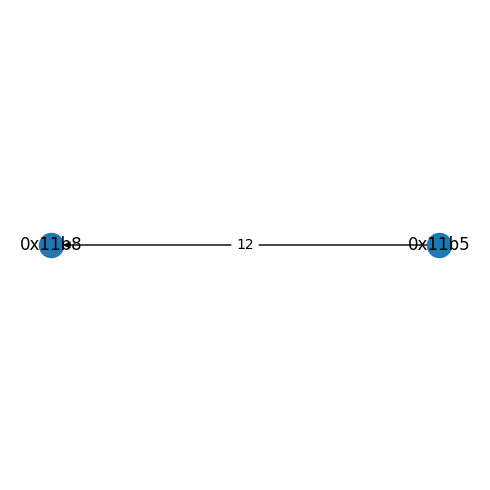

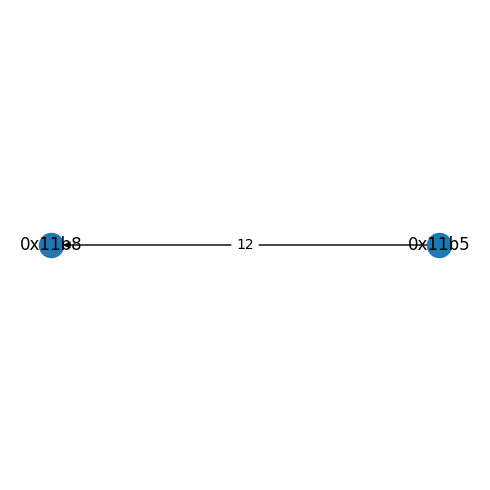

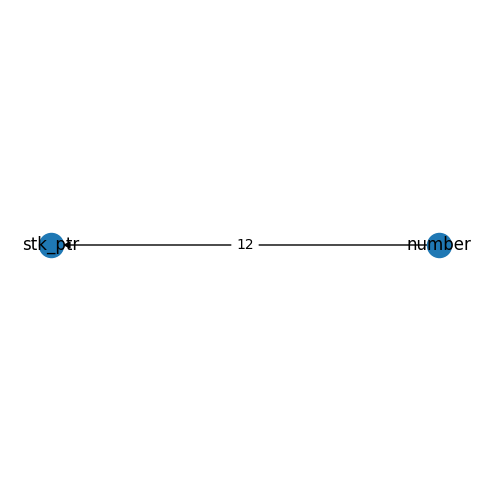

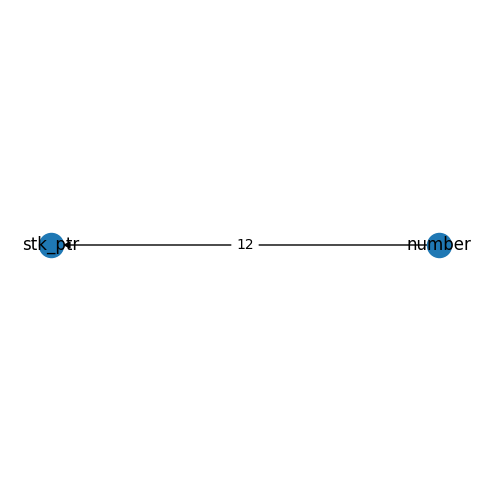

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  7 
ADDs: [4540]
>>:   0x11bc 0x11bc -24
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  8 
ADDs: [4547]
>>:   0x11c3 0x11c3 -20
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  12 
ADDs: [4554, 4558, 4561]
>>:   0x11ca 0x11ca -48
>>:   0x11d1 0x11d1 -16


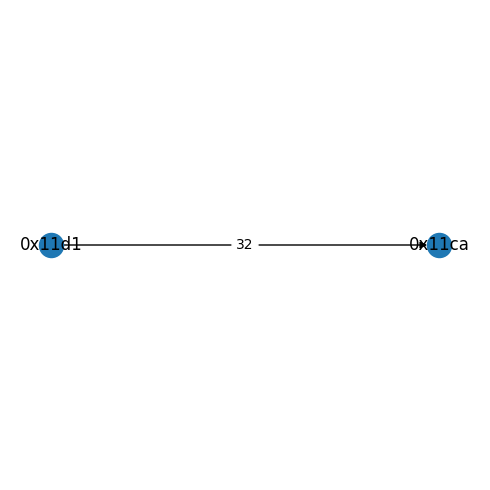

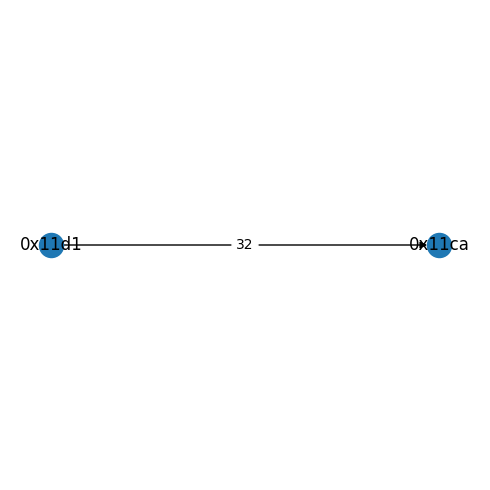

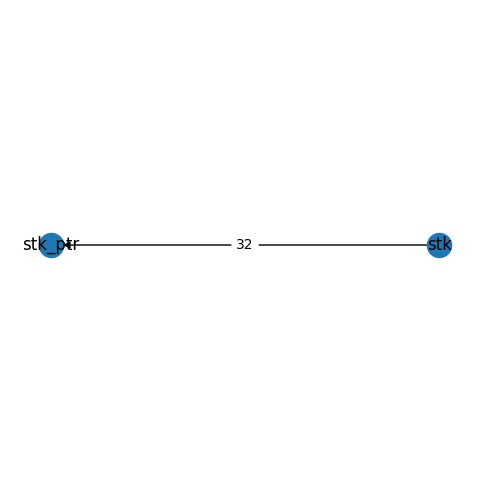

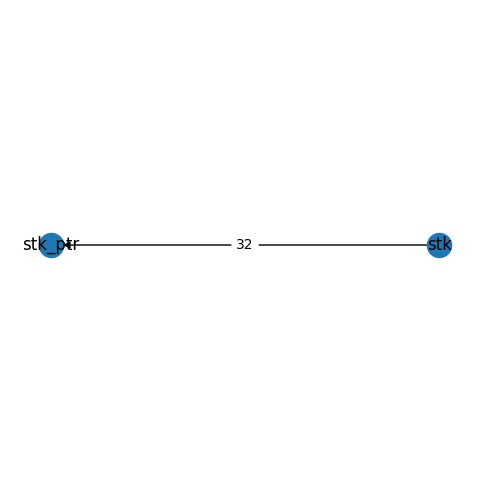

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  13 
ADDs: [4565, 4570, 4575]
>>:   0x11df 0x11df -8
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  14 
ADDs: [4579, 4583, 4586]
>>:   0x11e3 0x11e3 -8
>>:   0x11e7 0x11e7 -36


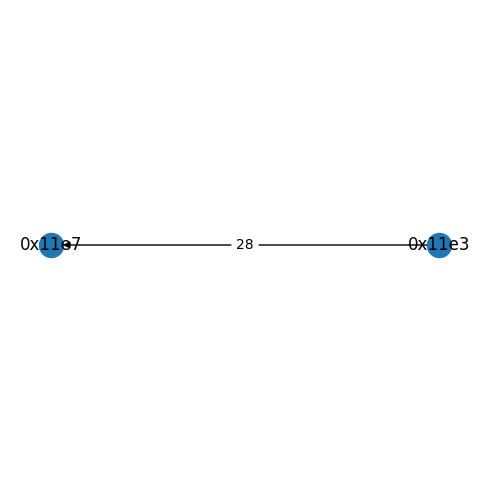

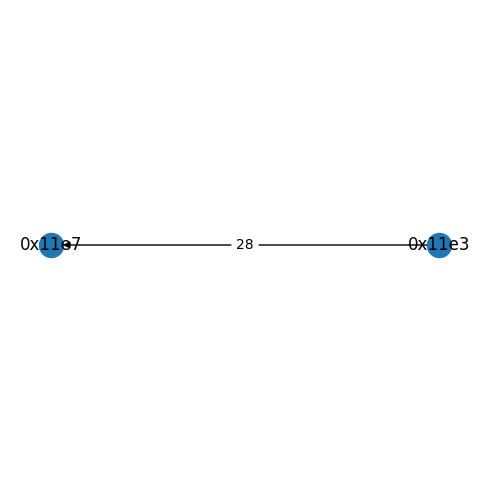

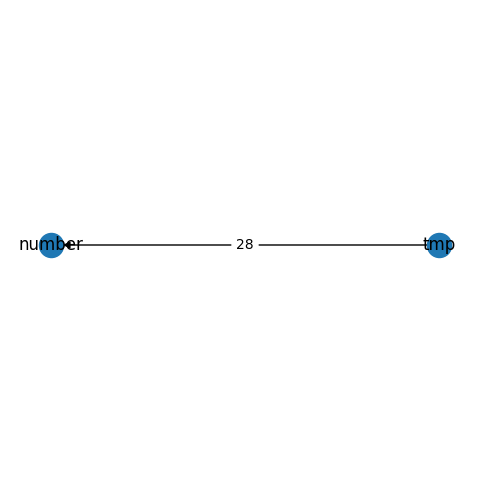

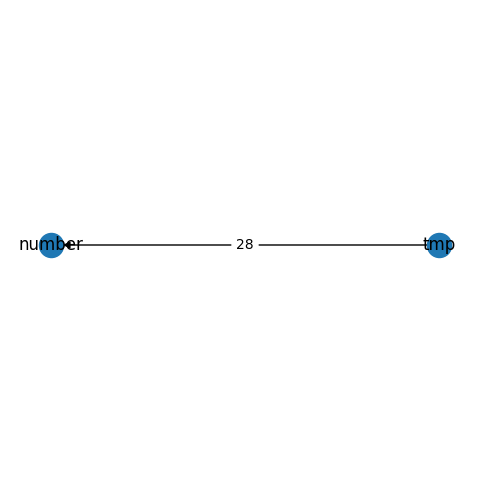

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  15 
ADDs: [4588, 4592, 4596]
>>:   0x11ec 0x11ec -8
>>:   0x11f0 0x11f0 -16
>>:   0x11f4 0x11f4 8


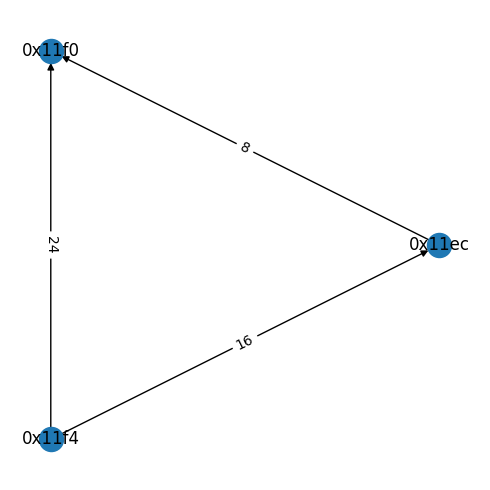

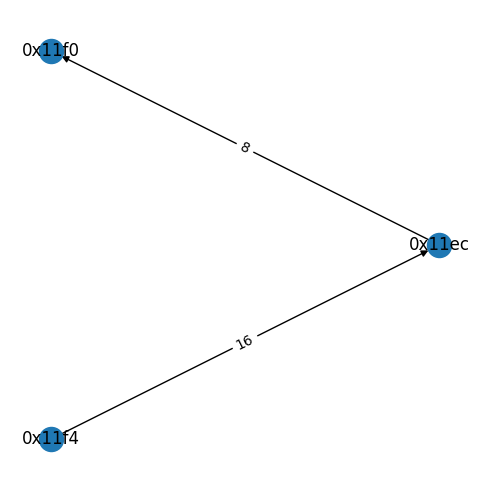

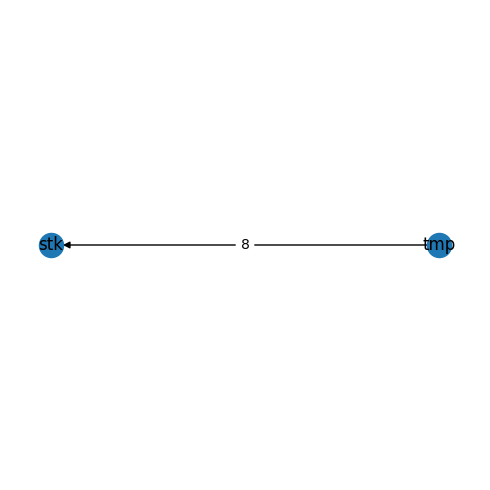

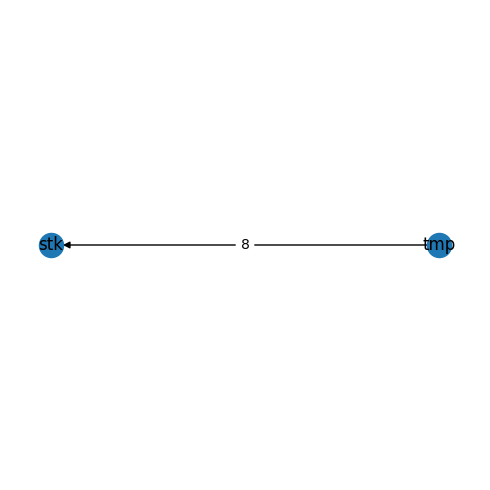

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  16 
ADDs: [4600, 4604]
>>:   0x11f8 0x11f8 -8
>>:   0x11fc 0x11fc -16


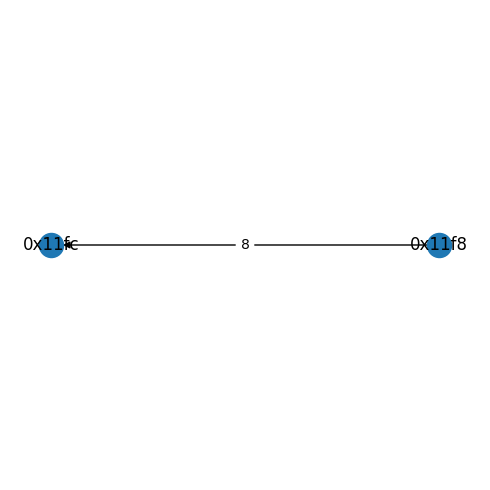

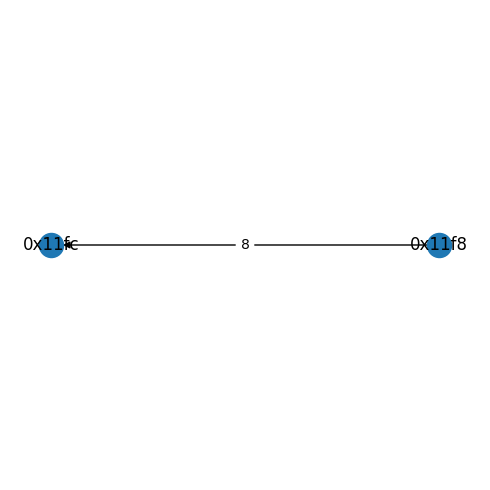

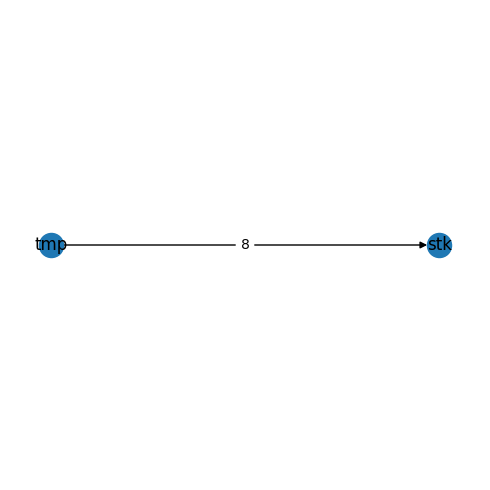

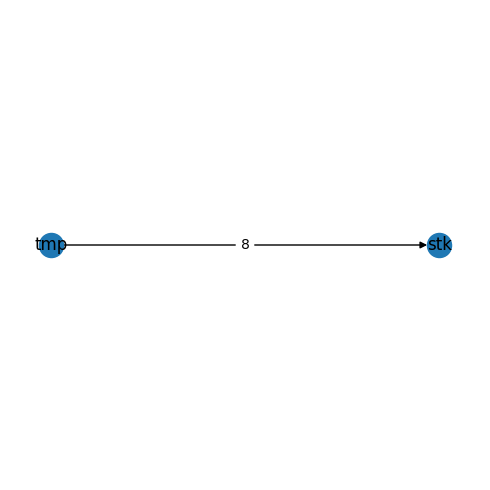

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  17 
ADDs: [4608, 4612, 4616]
>>:   0x1200 0x1200 -48
>>:   0x1204 0x1204 -16


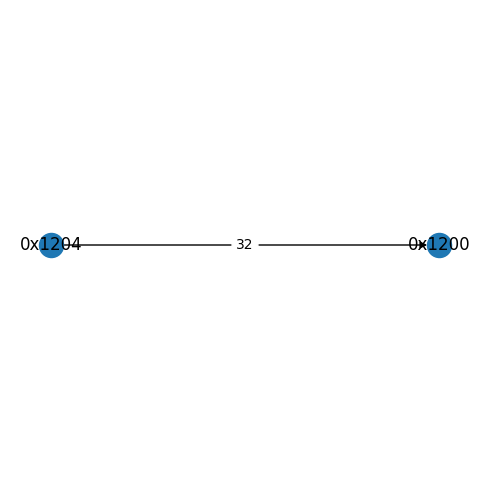

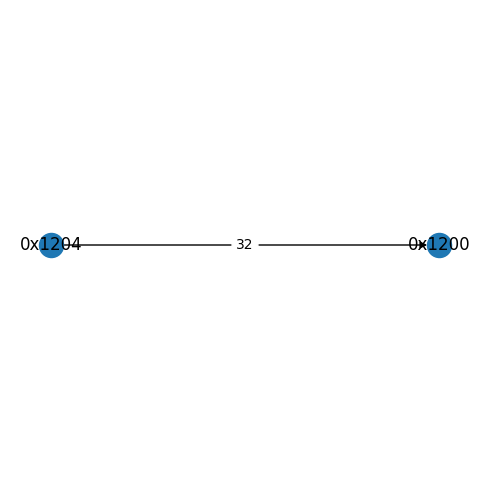

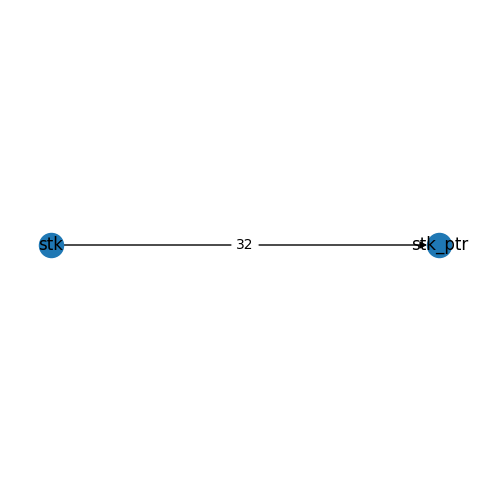

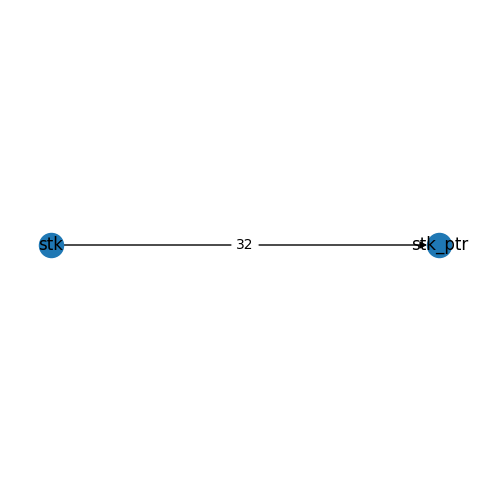

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  18 
ADDs: [4619, 4620, 4621]
NO NODES OR EDEGES 0 0
NO NODES OR EDEGES 0 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  19 
ADDs: [4622, 4626, 4627, 4630, 4637, 4643, 4651, 4659, 4666, 4675, 4679]
>>:   0x121d 0x121d -132
>>:   0x1223 0x1223 -136
>>:   0x122b 0x122b -144
>>:   0x1233 0x1233 -152
>>:   0x123a 0x123a 40
>>:   0x1243 0x1243 -8


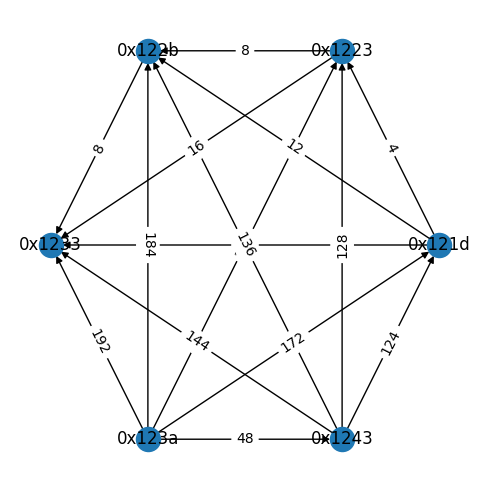

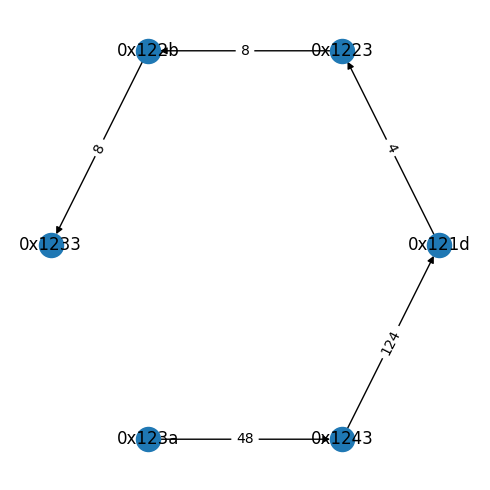

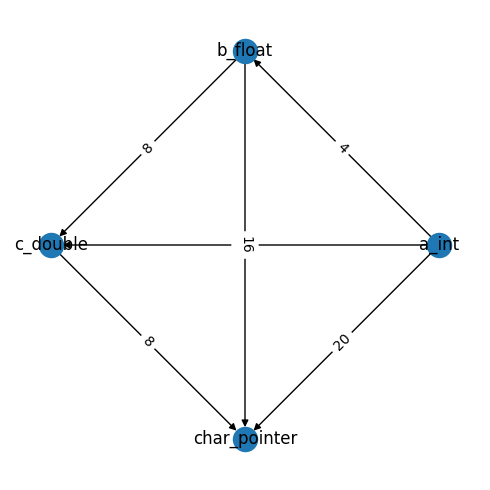

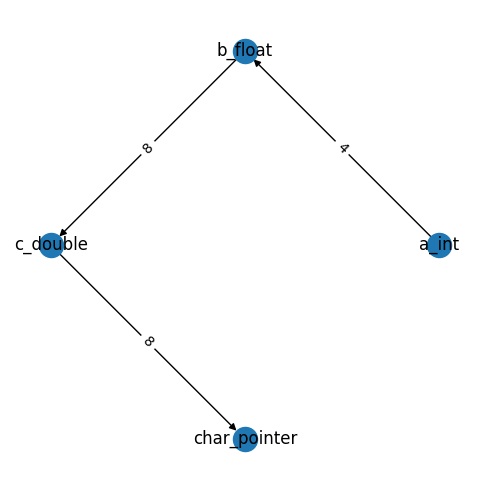

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  21 
ADDs: [4681]
>>:   0x1249 0x1249 -116
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  22 
ADDs: [4688, 4696]
>>:   0x1250 0x1250 3504
>>:   0x1258 0x1258 -112


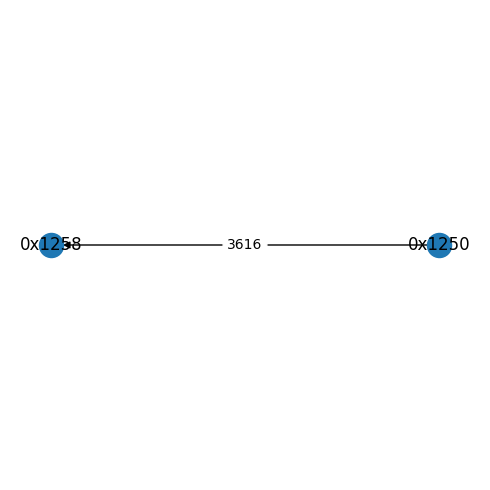

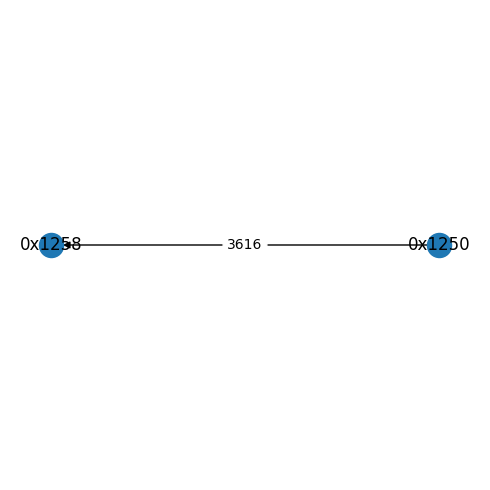

NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  23 
ADDs: [4701, 4709]
>>:   0x125d 0x125d 3499
>>:   0x1265 0x1265 -104


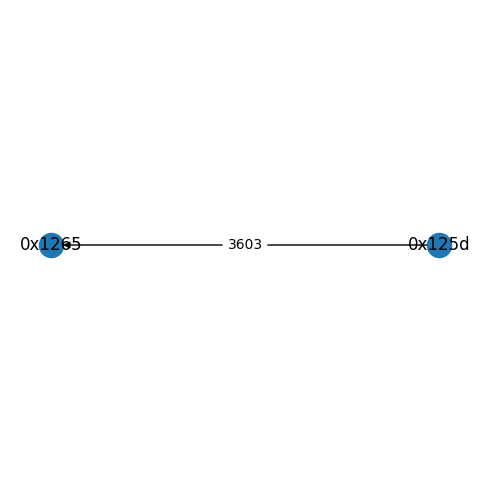

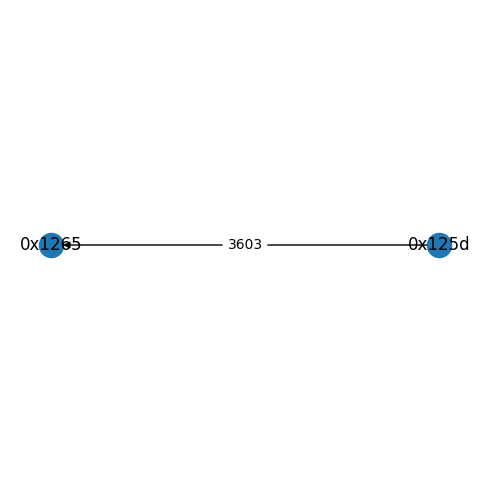

NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  25 
ADDs: [4714, 4720, 4722]
>>:   0x126a 0x126a -132
>>:   0x1272 0x1272 -116


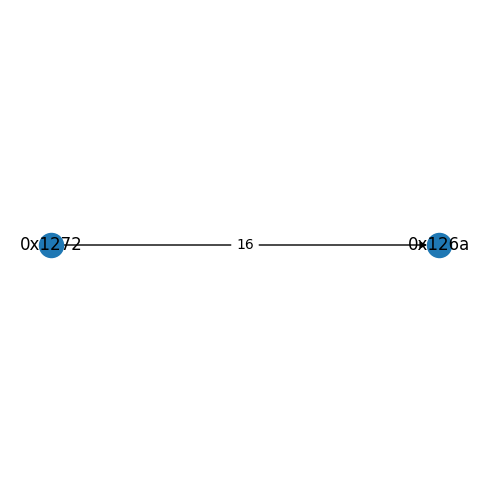

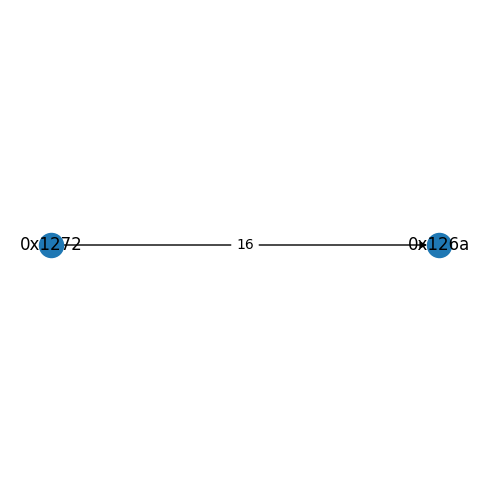

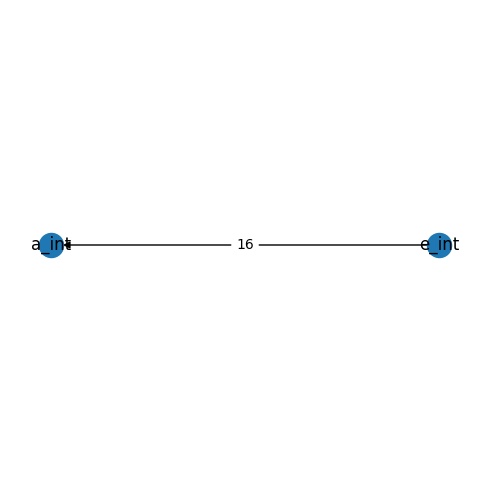

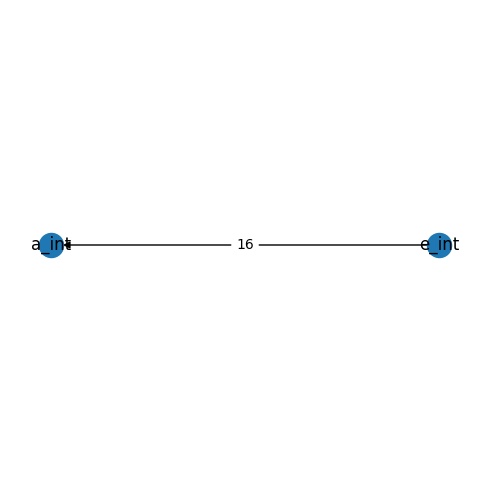

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  26 
ADDs: [4725, 4730, 4738]
>>:   0x1275 0x1275 -112
>>:   0x127a 0x127a -136


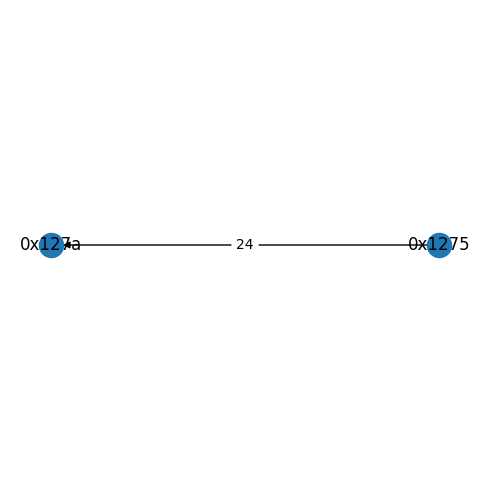

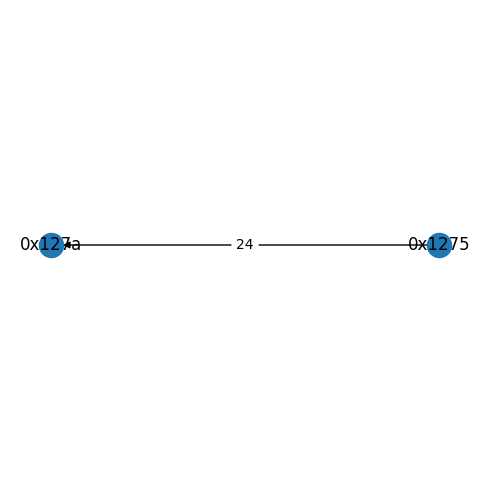

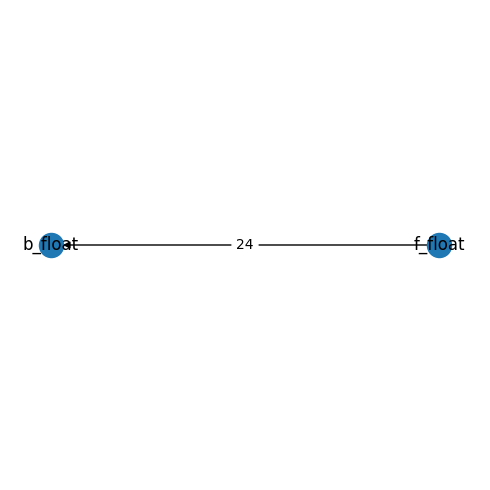

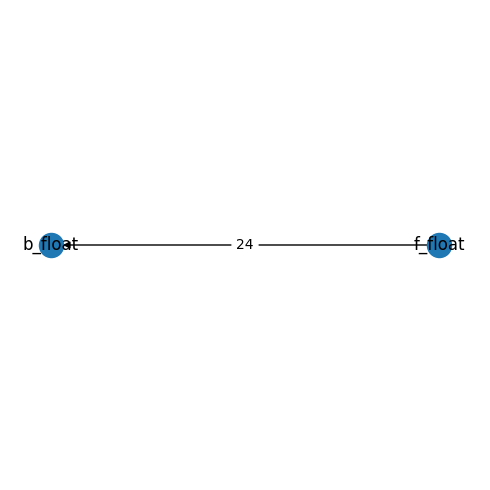

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  27 
ADDs: [4743, 4750, 4753, 4758, 4763]
>>:   0x1287 0x1287 -152
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  29 
ADDs: [4768]
>>:   0x12a0 0x12a0 -108
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 6 0
NO NODES OR EDEGES 6 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  31 
ADDs: [4775, 4782, 4800, 4804, 4808]
>>:   0x12a7 0x12a7 -120
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  32 
ADDs: [4784, 4787, 4788, 4791, 4794, 4796]
>>:   0x12b0 0x12b0 -116
>>:   0x12b4 0x12b4 -120
>>:   0x12bc 0x12bc -96


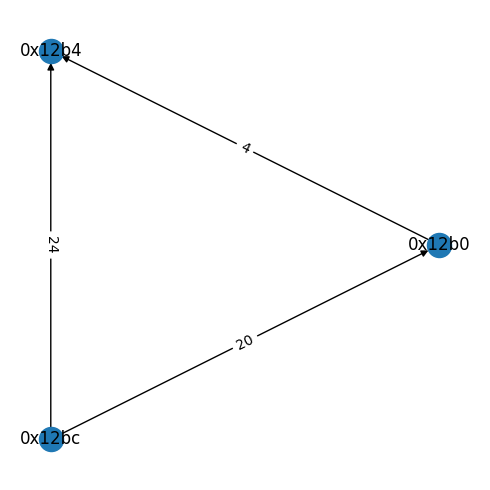

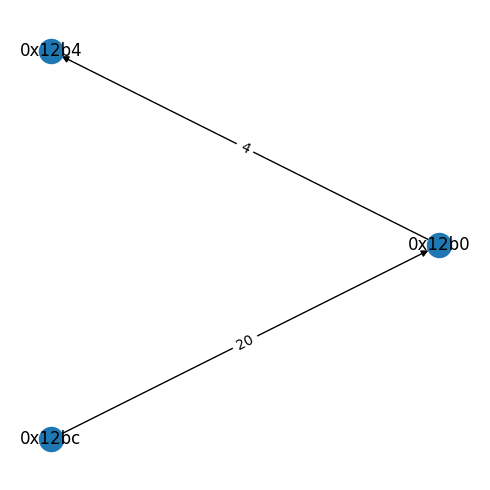

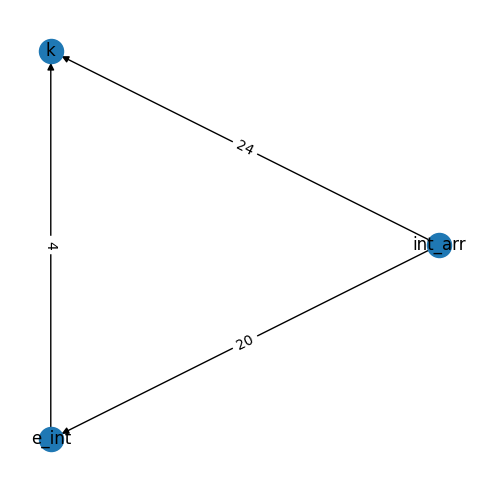

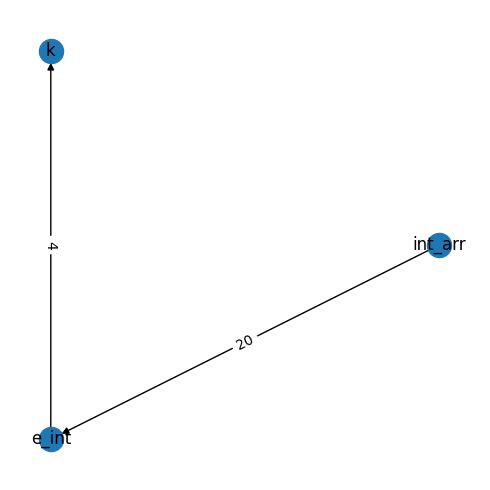

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  35 
ADDs: [4810, 4813]
>>:   0x12ca 0x12ca -116
>>:   0x12cd 0x12cd -132


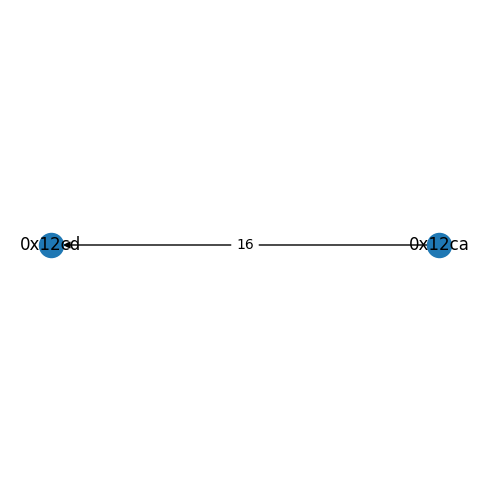

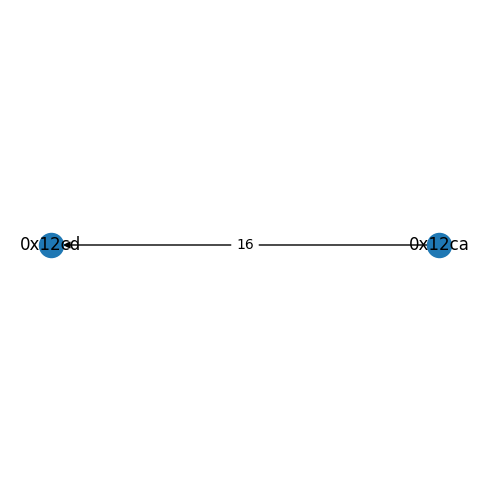

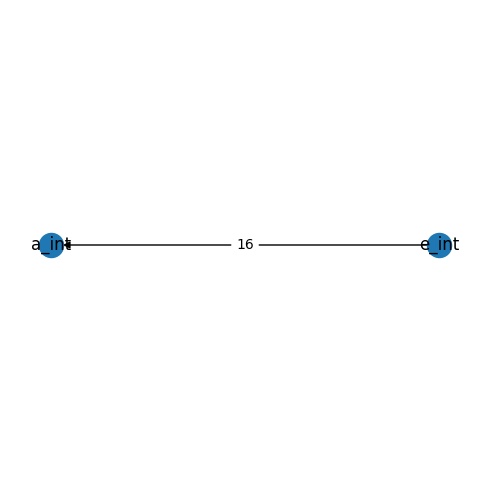

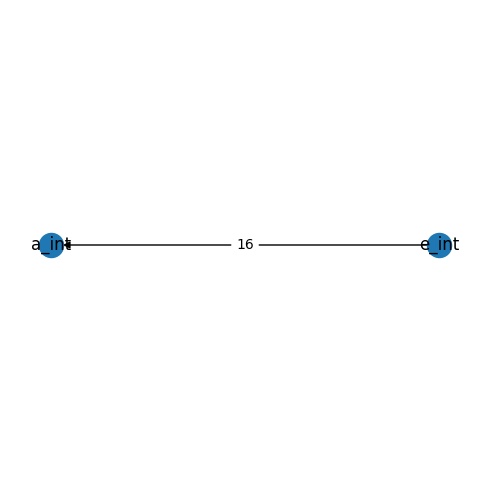

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  37 
ADDs: [4820, 4824, 4833, 4835, 4840, 4841]
>>:   0x12d4 0x12d4 -8
>>:   0x12d8 0x12d8 40


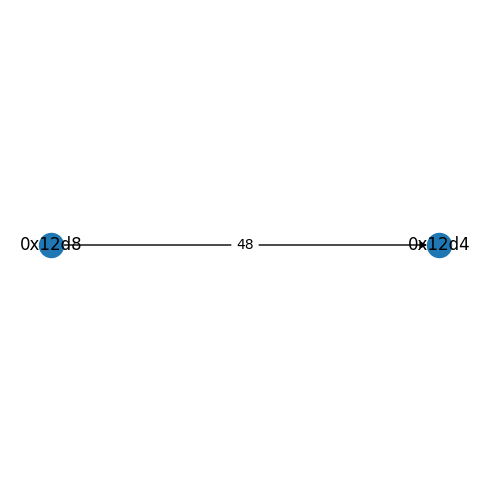

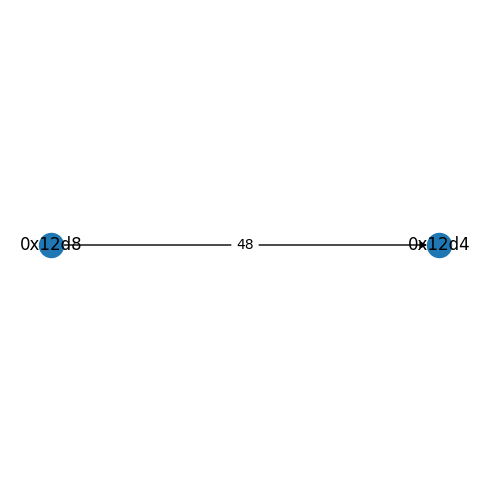

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  39 
ADDs: [4842, 4846, 4847, 4850, 4854]
>>:   0x12f6 0x12f6 -40
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  40 
ADDs: [4858]
>>:   0x12fa 0x12fa -28
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  41 
ADDs: [4865]
>>:   0x1301 0x1301 -24
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  44 
ADDs: [4872, 4876, 4879]
>>:   0x1308 0x1308 -40
>>:   0x130f 0x130f -16


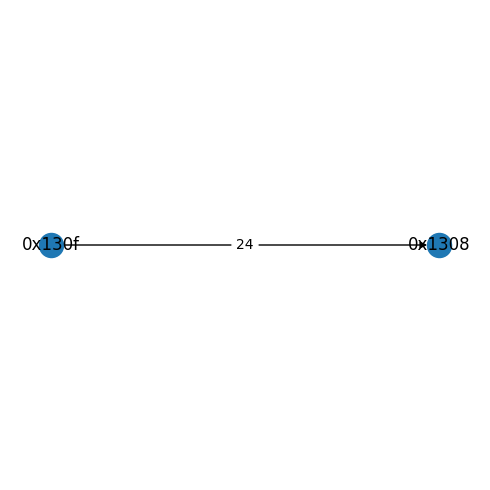

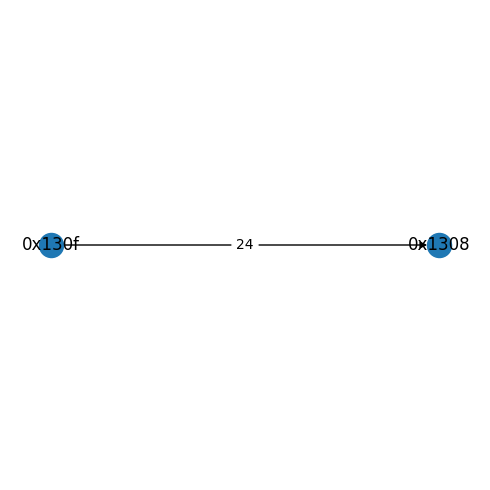

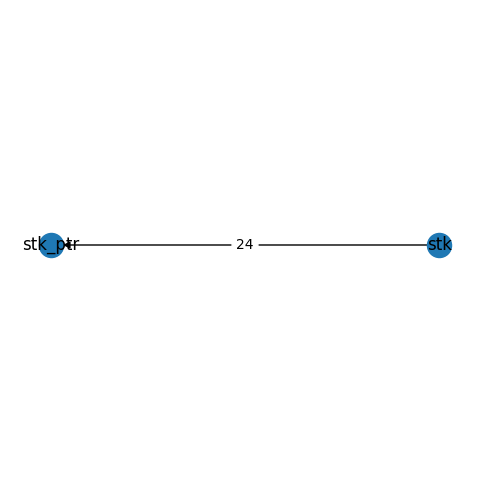

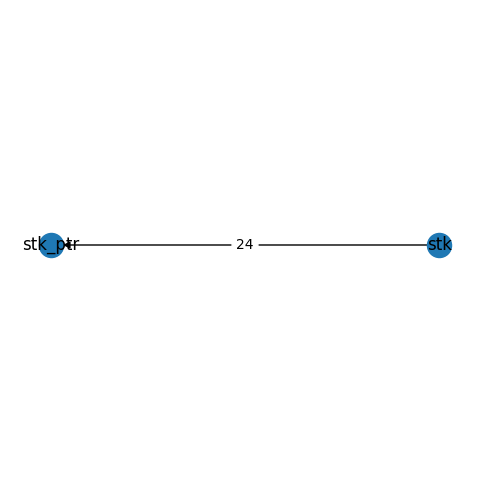

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  45 
ADDs: [4883, 4887]
>>:   0x1313 0x1313 -16
>>:   0x1317 0x1317 -8


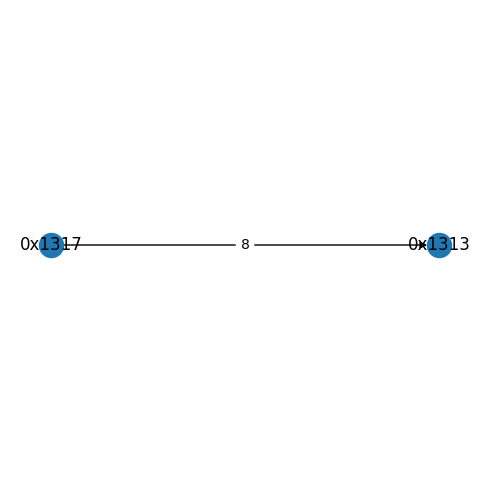

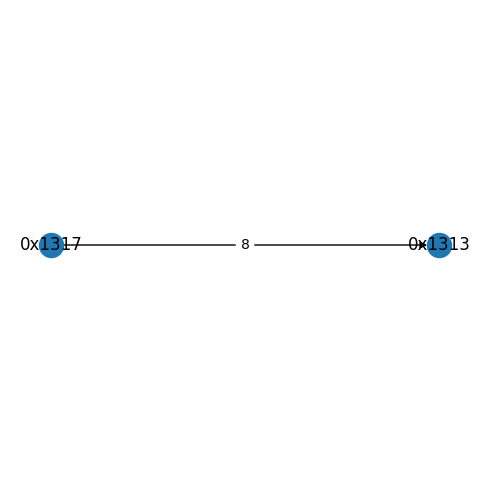

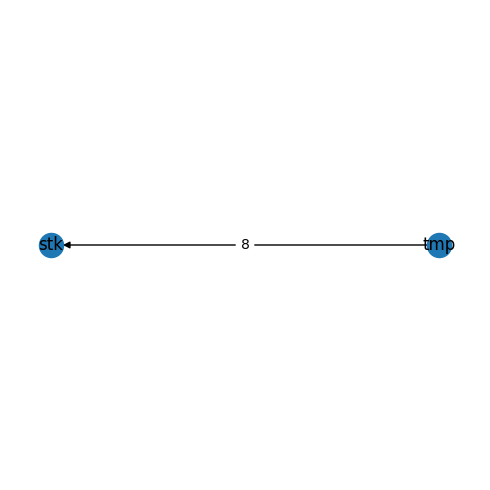

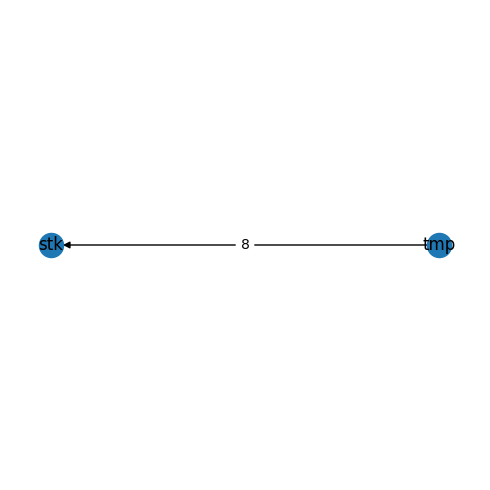

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  46 
ADDs: [4891, 4895, 4897]
>>:   0x131b 0x131b -8
>>:   0x1321 0x1321 -20


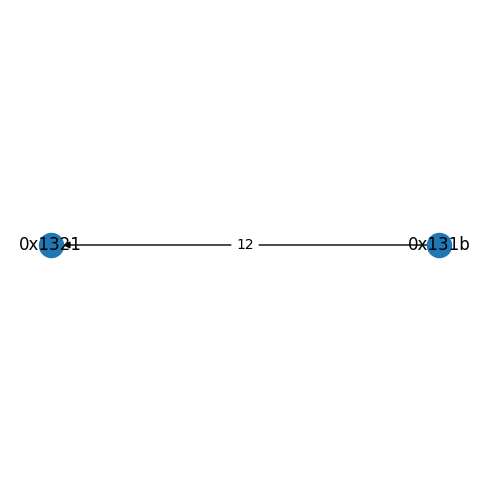

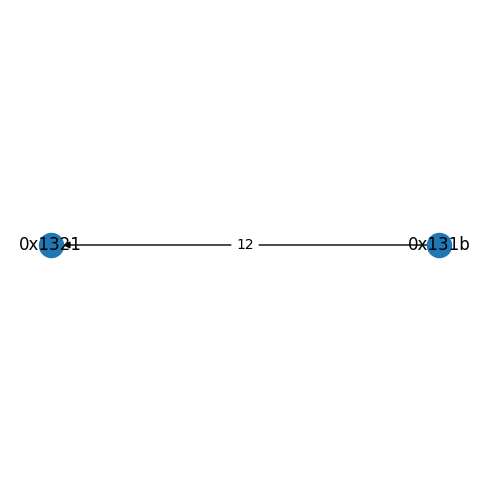

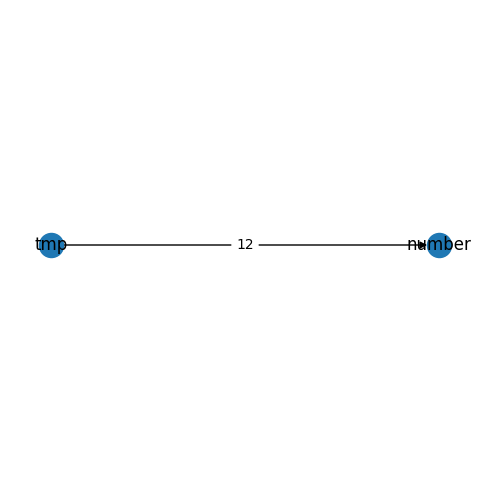

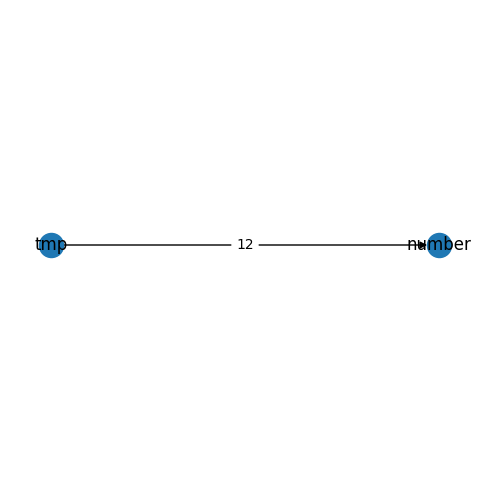

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  47 
ADDs: [4900, 4904, 4908]
>>:   0x1324 0x1324 -16
>>:   0x1328 0x1328 8


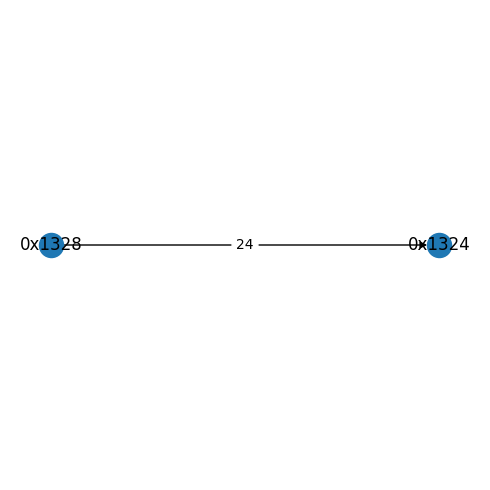

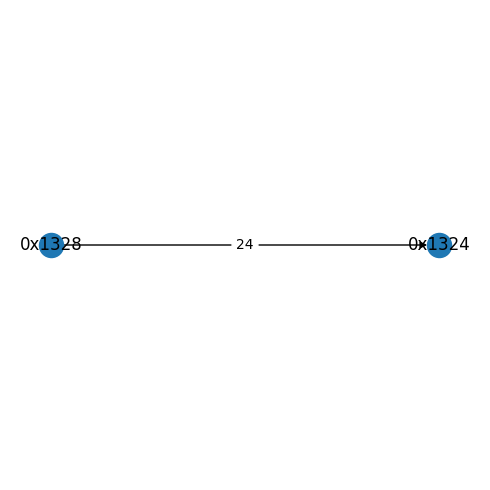

NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  48 
ADDs: [4912, 4916, 4919]
>>:   0x1330 0x1330 -8
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  49 
ADDs: [4924, 4928, 4932]
>>:   0x133c 0x133c -40
>>:   0x1340 0x1340 -16


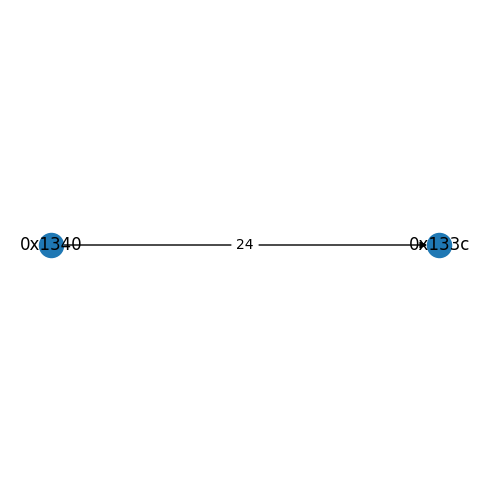

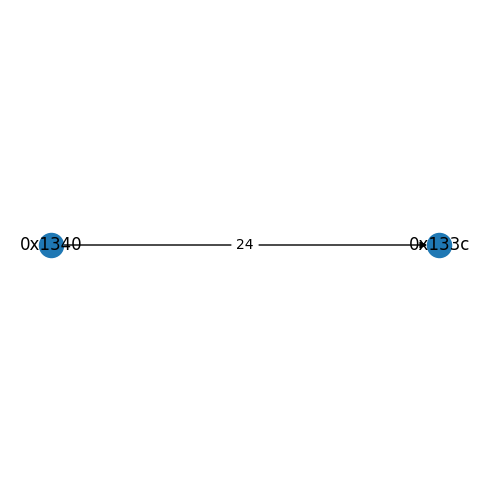

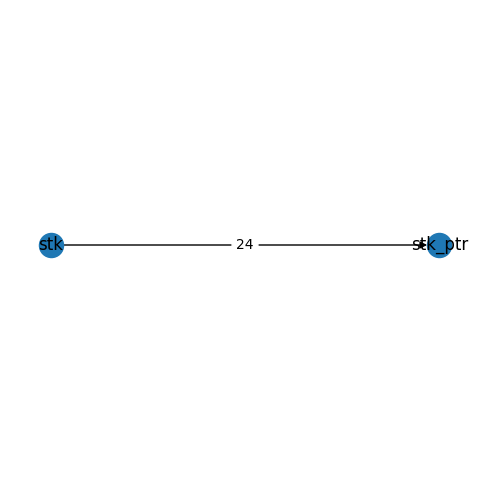

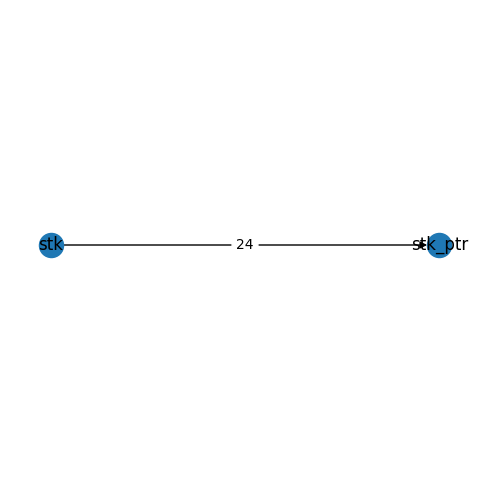

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  50 
ADDs: [4935]
>>:   0x1347 0x1347 -20
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  51 
ADDs: [4938, 4939]
NO NODES OR EDEGES 0 0
NO NODES OR EDEGES 0 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  53 
ADDs: [4940, 4944, 4945, 4948, 4951, 4954]
>>:   0x1354 0x1354 -20
>>:   0x1357 0x1357 -24
>>:   0x135a 0x135a -28


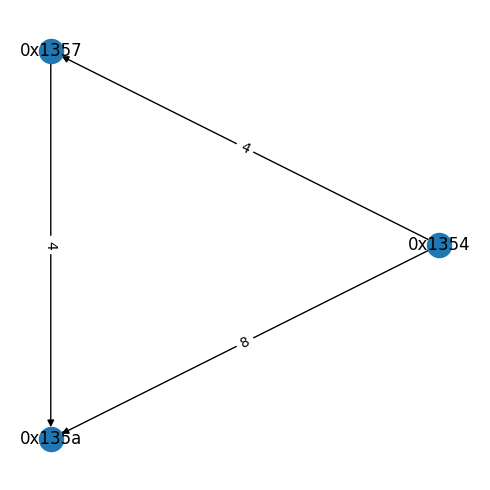

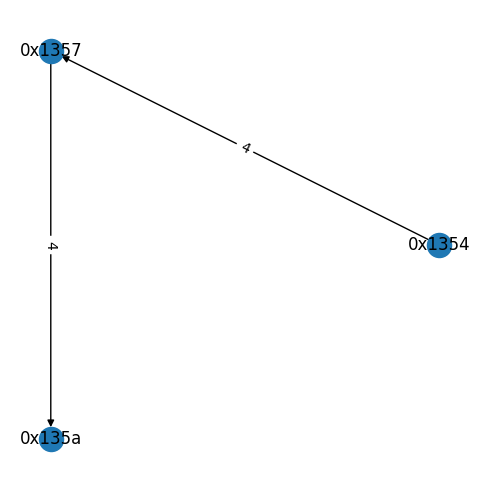

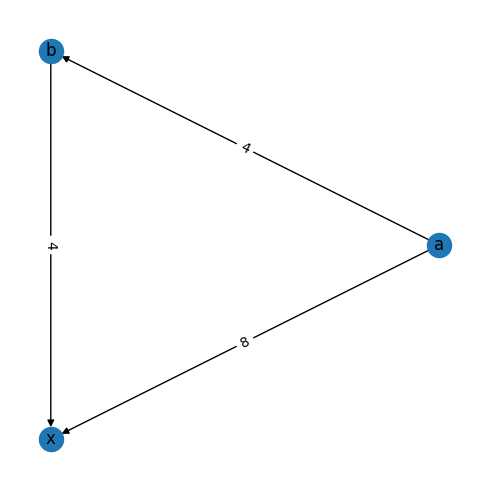

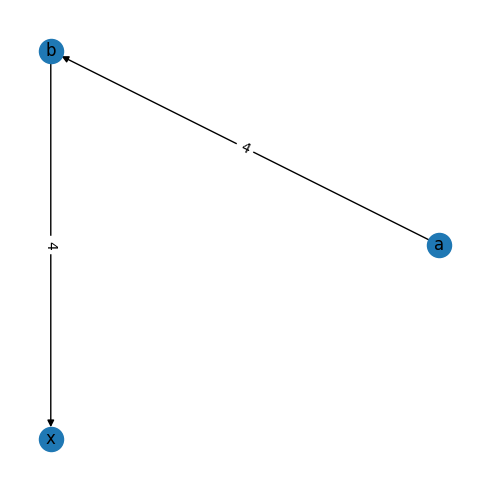

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  55 
ADDs: [4957]
>>:   0x135d 0x135d -16
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  56 
ADDs: [4964]
>>:   0x1364 0x1364 -12
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  57 
ADDs: [4971]
>>:   0x136b 0x136b -8
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  59 
ADDs: [4978, 4981, 4984, 4986, 4989, 4991, 4994, 4996, 4999, 5001]
>>:   0x1372 0x1372 -20
>>:   0x1375 0x1375 -24
>>:   0x137a 0x137a -16
>>:   0x137f 0x137f -12
>>:   0x1384 0x1384 -8
>>:   0x1389 0x1389 -4


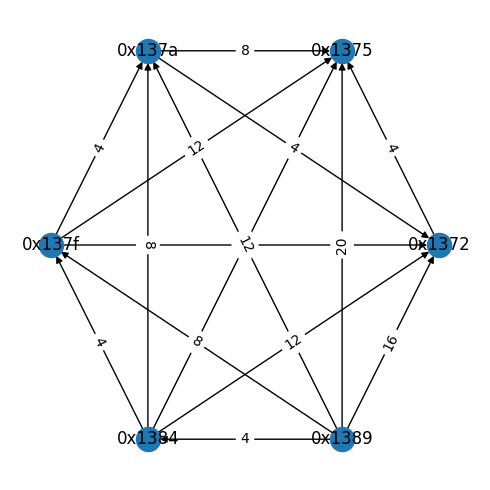

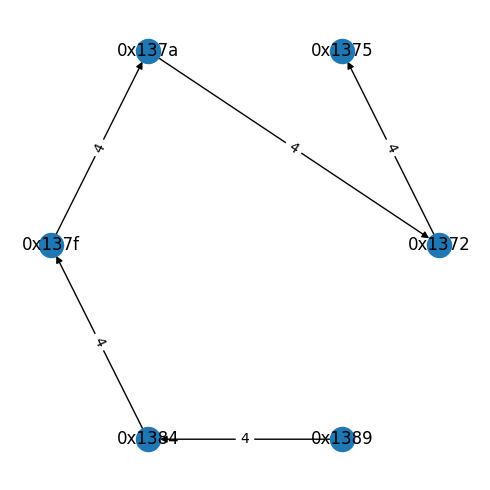

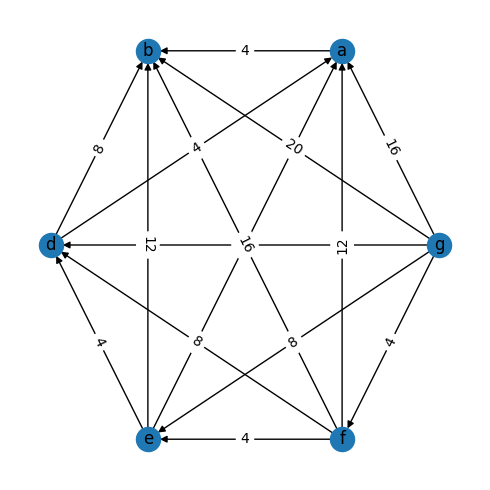

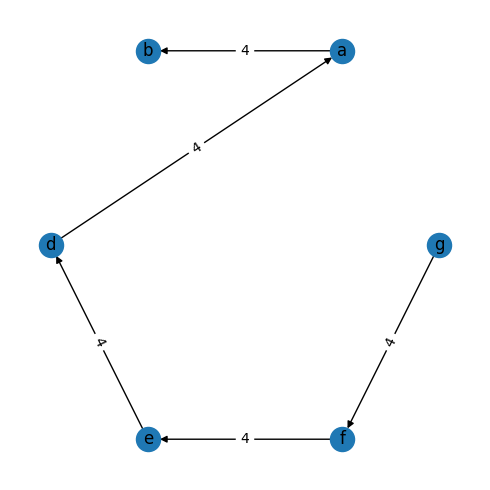

file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  60 
ADDs: [5004]
>>:   0x138c 0x138c -4
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
NO NODES OR EDEGES 1 0
file:  /home/nahid/reverse/binaries/c_many/stack.c 
line:  65 
ADDs: [5007, 5008]
NO NODES OR EDEGES 0 0
NO NODES OR EDEGES 0 0


In [13]:
def draw_graph(g):
    
    if g.number_of_nodes()==0 or g.number_of_edges()==0:
        print("NO NODES OR EDEGES" , g.number_of_nodes(), g.number_of_edges())
        return
    sorted(g.degree, key=lambda x: x[1], reverse=True)

    fig = matplotlib.pyplot.figure(figsize=(5,5))
    pos = nx.circular_layout(g)
    edge_labels = nx.get_edge_attributes(g, 'length')
    nx.draw(g, pos, ax=fig.add_subplot(),with_labels=True)
    nx.draw_networkx_edge_labels(g,pos, edge_labels=edge_labels)
    fig.tight_layout()
    if False: 
        # Save plot to file


        matplotlib.use("Agg") 
        fig.savefig("graph.png")
    else:
        # Display interactive viewer
        matplotlib.pyplot.show()

def prune_graph(G):

    for node in list(G.nodes()): #make copy. or deletion creates issues
        outgoing_edeges = G.out_edges(node)
        if len(outgoing_edeges)<2:
            continue
        #find minimum edege
        min_edege_length = None
        for out_edege in list(outgoing_edeges):
            if min_edege_length==None:
                min_edege_length = G.get_edge_data(*out_edege)['length']

            node_edege_length = G.get_edge_data(*out_edege)['length']

            if node_edege_length<min_edege_length:
                min_edege_length = node_edege_length
        #delete all except min
        for out_edege in list(outgoing_edeges):
            node_edege_length = G.get_edge_data(*out_edege)['length']
            if node_edege_length>min_edege_length:
                G.remove_edge(*out_edege)

#todo try func to address 
def build_line_to_relatedAddresses_matrix(address_lineinfo):#lineinfo_address_subprogram_complete
    line_address = {}
    for address  in VALID_INSTRUCTIONS_SET:#address_lineinfo.items():
        info = address_lineinfo[address]
        line          = info['lineinfo'].line
        col           = info['lineinfo'].column
        src_filepath  = info['srcPath']
        func          = info['func']
        
        if src_filepath not in line_address:
            line_address[src_filepath] ={}
        if func not in line_address[src_filepath]:
            line_address[src_filepath][func] = {}
        if line not in line_address[src_filepath][func]:
            line_address[src_filepath][func][line] = []
        
        line_address[src_filepath][func][line].append(address)
        
    return line_address
         
# def get    
    
line_to_address_matrix = build_line_to_relatedAddresses_matrix(lineinfo_address_subprogram_complete)

for cu_path, all_func_data in line_to_address_matrix.items():
    for func, func_data in all_func_data.items():
        for line, line_addresses in func_data.items():
            print('file: ',cu_path,'\nline: ',line, '\nADDs:' ,line_addresses)
            
            #################### PROCESS ADDRESS LIST ##############################
            
            inst_graph = nx.DiGraph()
            for address in line_addresses:
                address_hex = hex(address)
                inst = VALID_INSTRUCTIONS_SET[address]
                instrctionCode = (address_hex+":\t"+ inst.mnemonic+" "+inst.op_str).ljust(45)

                disp = None
                if len(inst.operands) > 0 :
                    oc=-1
                    for o in inst.operands:
                        oc += 1
                        if o.type == CS_OP_MEM:
#                             print("\t\toperands[%u].type: MEM" %oc)
#                             if o.value.mem.base != 0:
#                                 print("\t\t\toperands[%u].mem.base: REG = %s" \
#                                     %(oc, inst.reg_name(o.value.mem.base)))
#                             if o.value.mem.index != 0:
#                                 print("\t\t\toperands[%u].mem.index: REG = %s" \
#                                     %(oc, inst.reg_name(o.value.mem.index)))
                            if o.value.mem.disp != 0:
#                                 print("\t\t\toperands[%u].mem.disp: 0x%x" \
#                                     %(oc, o.value.mem.disp))
                                disp = o.value.mem.disp
                                
                                ###################################################################
                                ##### add node if node with same disp not added already ###########
                                ###################################################################
                                disp_to_node = {}
                                for node in inst_graph.nodes():
                                    disp_to_node[inst_graph.nodes[node]['disp']] = inst_graph.nodes[node]
#                                     nx.set_node_attributes(inst_graph, , "twins")
                                if disp in disp_to_node:
                                    
                                    if 'twins' in inst_graph.nodes[(node)]:
                                        curr_twins = inst_graph.nodes[ node]['twins']
                                        curr_twins.append(node)
                                        nx.set_node_attributes(inst_graph, curr_twins, "twins")
                                    else:
                                        nx.set_node_attributes(inst_graph, [node], "twins")
                                else:
                                    
                                    inst_graph.add_node(hex(address),inst_info = inst, disp = disp)
                                ################################
                                
                                
            
                            
            #process noeds
            for node1 in inst_graph.nodes():
                print('>>:  ',(node1),node1, inst_graph.nodes[node1]['disp'])
                for node2 in inst_graph.nodes():
                    if node1==node2:
                        continue
                    elif inst_graph.has_edge(node1, node2) or inst_graph.has_edge(node2, node1):
                        continue
                    else:
                        
                        node1_disp = inst_graph.nodes[node1]['disp']
                        node2_disp = inst_graph.nodes[node2]['disp']

                        if (node1_disp - node2_disp)>=0:
                            inst_graph.add_edge(node1, node2, length =  (node1_disp - node2_disp))
                        else:
                            inst_graph.add_edge(node2, node1, length =  (node2_disp - node1_disp))
            draw_graph(inst_graph)
            prune_graph(inst_graph)
            draw_graph(inst_graph)

            #######################  PROCESS SRC VARIABLES #############################
            if line in variables_in_line[cu_path]: #ALL LINES SHOULD BE VALID, should not check
                var_list = variables_in_line[cu_path][line]

                var_graph_src = nx.DiGraph()
                
                for col,var in var_list.items():
                    var_graph_src.add_node(var['name'], var_info = var)

                for c1,var_1 in var_list.items():
                    if 'location' not in var_1['dwarf_info']:
                        continue
                    for c2,var_2 in var_list.items():
                        if 'location' not in var_2['dwarf_info']:
                            continue
                        if var_1['name'] == var_2['name']:
                            continue
                        elif var_graph_src.has_edge(var_1['name'], var_2['name'])  or var_graph_src.has_edge(var_2['name'], var_1['name']):
                            continue
                        else:
                            var_1_offset = int(var_1['dwarf_info']['location'].split(':')[-1][:-1])
                            var_2_offset = int(var_2['dwarf_info']['location'].split(':')[-1][:-1])
                            if (var_1_offset - var_2_offset)>=0:
                                var_graph_src.add_edge(var_1['name'], var_2['name'], length =  (var_1_offset - var_2_offset))
                            else:
                                var_graph_src.add_edge(var_2['name'], var_1['name'], length =  (var_2_offset - var_1_offset))
                ### prune graph
                draw_graph(var_graph_src)
                prune_graph(var_graph_src)
                draw_graph(var_graph_src)

                ########################
                #break
        #break
        
    break
# line_to_address_matrix
# var_list


In [11]:

######################################3#########
########### ILLUSTRATE in file ##################
#################################################


REGISTER_SUBSTRACT_FACTOR = -0
dir_path = './../../binaries/c_many/'
with open(binFileName+'.s', 'w') as outFile:
    # outFile.write('file contents\n')
    lastSource = ""
    for address in VALID_INSTRUCTIONS_SET:
        address_hex = hex(address)
        print(address_hex)
        inst = VALID_INSTRUCTIONS_SET[address]
        instrctionCode = (address_hex+":\t"+ inst.mnemonic+" "+inst.op_str).ljust(45)

        OFFSET = None
        if len(inst.operands) > 0 :
            c=-1
            for o in inst.operands:
                c += 1
                if o.type == CS_OP_MEM:
                    print("\t\toperands[%u].type: MEM" %c)
                    if o.value.mem.base != 0:
                        print("\t\t\toperands[%u].mem.base: REG = %s" \
                            %(c, inst.reg_name(o.value.mem.base)))
                    if o.value.mem.index != 0:
                        print("\t\t\toperands[%u].mem.index: REG = %s" \
                            %(c, inst.reg_name(o.value.mem.index)))
                    if o.value.mem.disp != 0:
                        print("\t\t\toperands[%u].mem.disp: 0x%x" \
                            %(c, o.value.mem.disp))
                        OFFSET = o.value.mem.disp
                    print(hex(o.value.mem.disp),o.value.mem.disp)
                    

        if address in lineinfo_address_subprogram_complete:
            if lineinfo_address_subprogram_complete[address]['lineinfo'].address == address: 
                srcFilePath = lineinfo_address_subprogram_complete[address]['srcPath']
                if srcFilePath!=lastSource:
                    outFile.write("\n"+ '#'*100+"\n"+ srcFilePath.rjust(45) +'\n'+'#'*100+ "\n\n")
                    lastSource = srcFilePath


                src_line_no  = lineinfo_address_subprogram_complete[address]['lineinfo'].line
                src_col_no   = lineinfo_address_subprogram_complete[address]['lineinfo'].column
                sourceCode = getSource(srcFilePath,src_line_no, src_col_no)
                function_name = lineinfo_address_subprogram_complete[address]['func']
                
                print('##############',sourceCode)

                if '\n' not in  sourceCode:
                    sourceCode+=sourceCode+"\n"
                outFile.write(instrctionCode+"#"+ sourceCode  )
                print(instrctionCode+"#"+ sourceCode)



            else:

                outFile.write(instrctionCode+ '\n'  )
                print(instrctionCode)
            if OFFSET:
                outFile.write("MEMORY OFFSET:     "+str(hex(OFFSET))+"     "+str(OFFSET)+ "  >>"+str(OFFSET-REGISTER_SUBSTRACT_FACTOR)+'\n\n')
                pass

0x11a9
/home/nahid/reverse/binaries/c_many/stack.c 6 40
############## void push(int number, stack **stk_ptr) |{|

0x11a9:	endbr64                              #void push(int number, stack **stk_ptr) |{|

0x11ad
0x11ad:	push rbp                             
0x11ae
0x11ae:	mov rbp, rsp                         
0x11b1
0x11b1:	sub rsp, 0x30                        
0x11b5
		operands[0].type: MEM
			operands[0].mem.base: REG = rbp
			operands[0].mem.disp: 0x-24
-0x24 -36
0x11b5:	mov dword ptr [rbp - 0x24], edi      
0x11b8
		operands[0].type: MEM
			operands[0].mem.base: REG = rbp
			operands[0].mem.disp: 0x-30
-0x30 -48
0x11b8:	mov qword ptr [rbp - 0x30], rsi      
0x11bc
		operands[0].type: MEM
			operands[0].mem.base: REG = rbp
			operands[0].mem.disp: 0x-18
-0x18 -24
/home/nahid/reverse/binaries/c_many/stack.c 7 9
##############     int |p|op = 10;

0x11bc:	mov dword ptr [rbp - 0x18], 0xa      #    int |p|op = 10;

0x11c3
		operands[0].type: MEM
			operands[0].mem.base: REG = rbp
			ope